In [8]:
import os, gc
import sys, pdb
import copy, time
import json, random
import time

import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from pathlib import Path

import matplotlib
from matplotlib import colors
import matplotlib.pyplot as plt
from colorama import Style, Fore
%matplotlib inline

In [9]:

import signal
import psutil
import itertools
import subprocess
import base64, gzip
import networkx as nx
import multiprocessing
#::::::::::::::::::::::::::::::::::::::::::::::
from numpy import array
from pathlib import Path
from scipy import ndimage
from scipy.stats import mode
from tqdm.auto import trange
from functools import partial
from tqdm.notebook import tqdm
from PIL import Image, ImageDraw
from xgboost import XGBClassifier
from itertools import combinations, product
from collections import defaultdict, Counter
from skimage.measure import label, regionprops
#::::::::::::::::::::::::::::::::::::::::::::::
from sklearn.tree import *
from sklearn import tree
from sklearn.ensemble import BaggingClassifier
from skimage.measure import label, regionprops
from sklearn.preprocessing import MinMaxScaler

from subprocess import Popen, PIPE, STDOUT
from glob import glob

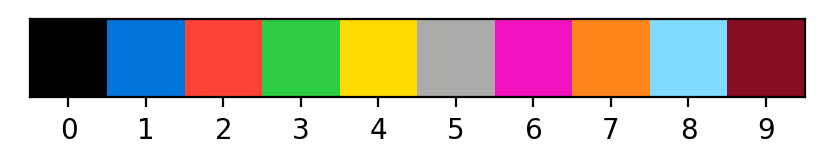

In [10]:
train1_path = '../input/arc-prize-2024/arc-agi_training_challenges.json'
train2_path = '../input/arc-prize-2024/arc-agi_training_solutions.json'

eval1_path = '../input/arc-prize-2024/arc-agi_evaluation_challenges.json'
eval2_path = '../input/arc-prize-2024/arc-agi_evaluation_solutions.json'

test_path = '../input/arc-prize-2024/arc-agi_test_challenges.json'
sample_path = '../input/arc-prize-2024/sample_submission.json'

# ......................................................................................................
cmap = colors.ListedColormap(
    ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
     '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])

norm = colors.Normalize(vmin=0, vmax=9)
color_list = ["black", "blue", "red", "green", "yellow", "gray", "magenta", "orange", "sky", "brown"]

# ......................................................................................................
plt.figure(figsize=(5, 2), dpi=200)
plt.imshow([list(range(10))], cmap=cmap, norm=norm)
plt.xticks(list(range(10)))
plt.yticks([])
plt.show()

In [11]:
# ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
def plot_pic(x):
    plt.imshow(np.array(x), cmap=cmap, norm=norm)
    plt.show()
    
# ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
def plot_data(task):
    n = len(task["train"]) + len(task["test"])
    fig, axs = plt.subplots(2, n, figsize=(4*n,8), dpi=200)
    plt.subplots_adjust(wspace=0, hspace=0)
    fig_num = 0
    for i, t in enumerate(task["train"]):
        t_in, t_out = np.array(t["input"]), np.array(t["output"])
        axs[0][fig_num].imshow(t_in, cmap=cmap, norm=norm)
        axs[0][fig_num].set_title(f'Train-{i} in')
        axs[0][fig_num].set_yticks(list(range(t_in.shape[0])))
        axs[0][fig_num].set_xticks(list(range(t_in.shape[1])))
        axs[1][fig_num].imshow(t_out, cmap=cmap, norm=norm)
        axs[1][fig_num].set_title(f'Train-{i} out')
        axs[1][fig_num].set_yticks(list(range(t_out.shape[0])))
        axs[1][fig_num].set_xticks(list(range(t_out.shape[1])))
        fig_num += 1
    for i, t in enumerate(task["test"]):
        t_in, t_out = np.array(t["input"]), np.array(t["output"])
        axs[0][fig_num].imshow(t_in, cmap=cmap, norm=norm)
        axs[0][fig_num].set_title(f'Test-{i} in')
        axs[0][fig_num].set_yticks(list(range(t_in.shape[0])))
        axs[0][fig_num].set_xticks(list(range(t_in.shape[1])))
        axs[1][fig_num].imshow(t_out, cmap=cmap, norm=norm)
        axs[1][fig_num].set_title(f'Test-{i} out')
        axs[1][fig_num].set_yticks(list(range(t_out.shape[0])))
        axs[1][fig_num].set_xticks(list(range(t_out.shape[1])))
        fig_num += 1
    
    plt.tight_layout()
    plt.show()
    
# ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
def plot_task(task):
    n = len(task["train"]) + len(task["test"])
    fig, axs = plt.subplots(2, n, figsize=(4*n,8), dpi=200)
    plt.subplots_adjust(wspace=0, hspace=0)
    fig_num = 0
    for i, t in enumerate(task["train"]):
        t_in, t_out = np.array(t["input"]), np.array(t["output"])
        axs[0][fig_num].imshow(t_in, cmap=cmap, norm=norm)
        axs[0][fig_num].set_title(f'Train-{i} in')
        axs[0][fig_num].set_yticks(list(range(t_in.shape[0])))
        axs[0][fig_num].set_xticks(list(range(t_in.shape[1])))
        axs[1][fig_num].imshow(t_out, cmap=cmap, norm=norm)
        axs[1][fig_num].set_title(f'Train-{i} out')
        axs[1][fig_num].set_yticks(list(range(t_out.shape[0])))
        axs[1][fig_num].set_xticks(list(range(t_out.shape[1])))
        fig_num += 1
    for i, t in enumerate(task["test"]):
        t_in = np.array(t["input"])
        axs[0][fig_num].imshow(t_in, cmap=cmap, norm=norm)
        axs[0][fig_num].set_title(f'Test-{i} in')
        axs[0][fig_num].set_yticks(list(range(t_in.shape[0])))
        axs[0][fig_num].set_xticks(list(range(t_in.shape[1])))
        fig_num += 1
    
    plt.tight_layout()
    plt.show()  
    
# ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::


In [29]:
train1_icecube_out = 'absres-c-files/train_submission_part.csv'
test_icecube_out = 'absres-c-files/test_submission_part.csv'
eval1_icecube_out = 'absres-c-files/evaluation_submission_part.csv'

# Function to translate from old submission format (csv) to new one (json)
def translate_submission(file_path, output_path='sub_icecube.json'):
    # Read the original submission file
    with open(file_path, 'r') as file:
        lines = file.readlines()

    submission_dict = {}

    for line in lines[1:]:  # Skip the header line
        output_id, output = line.strip().split(',')
        task_id, output_idx = output_id.split('_')
        predictions = output.split(' ')  # Split predictions based on ' '
        
        # Take only the first two predictions
        if len(predictions) > 2:
            predictions = predictions[:2]

        processed_predictions = []
        for pred in predictions:
            if pred:  # Check if pred is not an empty string
                pred_lines = pred.split('|')[1:-1]  # Remove empty strings from split
                pred_matrix = [list(map(int, line)) for line in pred_lines]
                processed_predictions.append(pred_matrix)

        attempt_1 = processed_predictions[0] if len(processed_predictions) > 0 else []
        attempt_2 = processed_predictions[1] if len(processed_predictions) > 1 else []

        if task_id not in submission_dict:
            submission_dict[task_id] = []

        attempt_dict = {
            "attempt_1": attempt_1,
            "attempt_2": attempt_2
        }

        if output_idx == '0':
            submission_dict[task_id].insert(0, attempt_dict)
        else:
            submission_dict[task_id].append(attempt_dict)
    
    # Write to the new json file
    with open(output_path, 'w') as file:
        json.dump(submission_dict, file, indent=4)

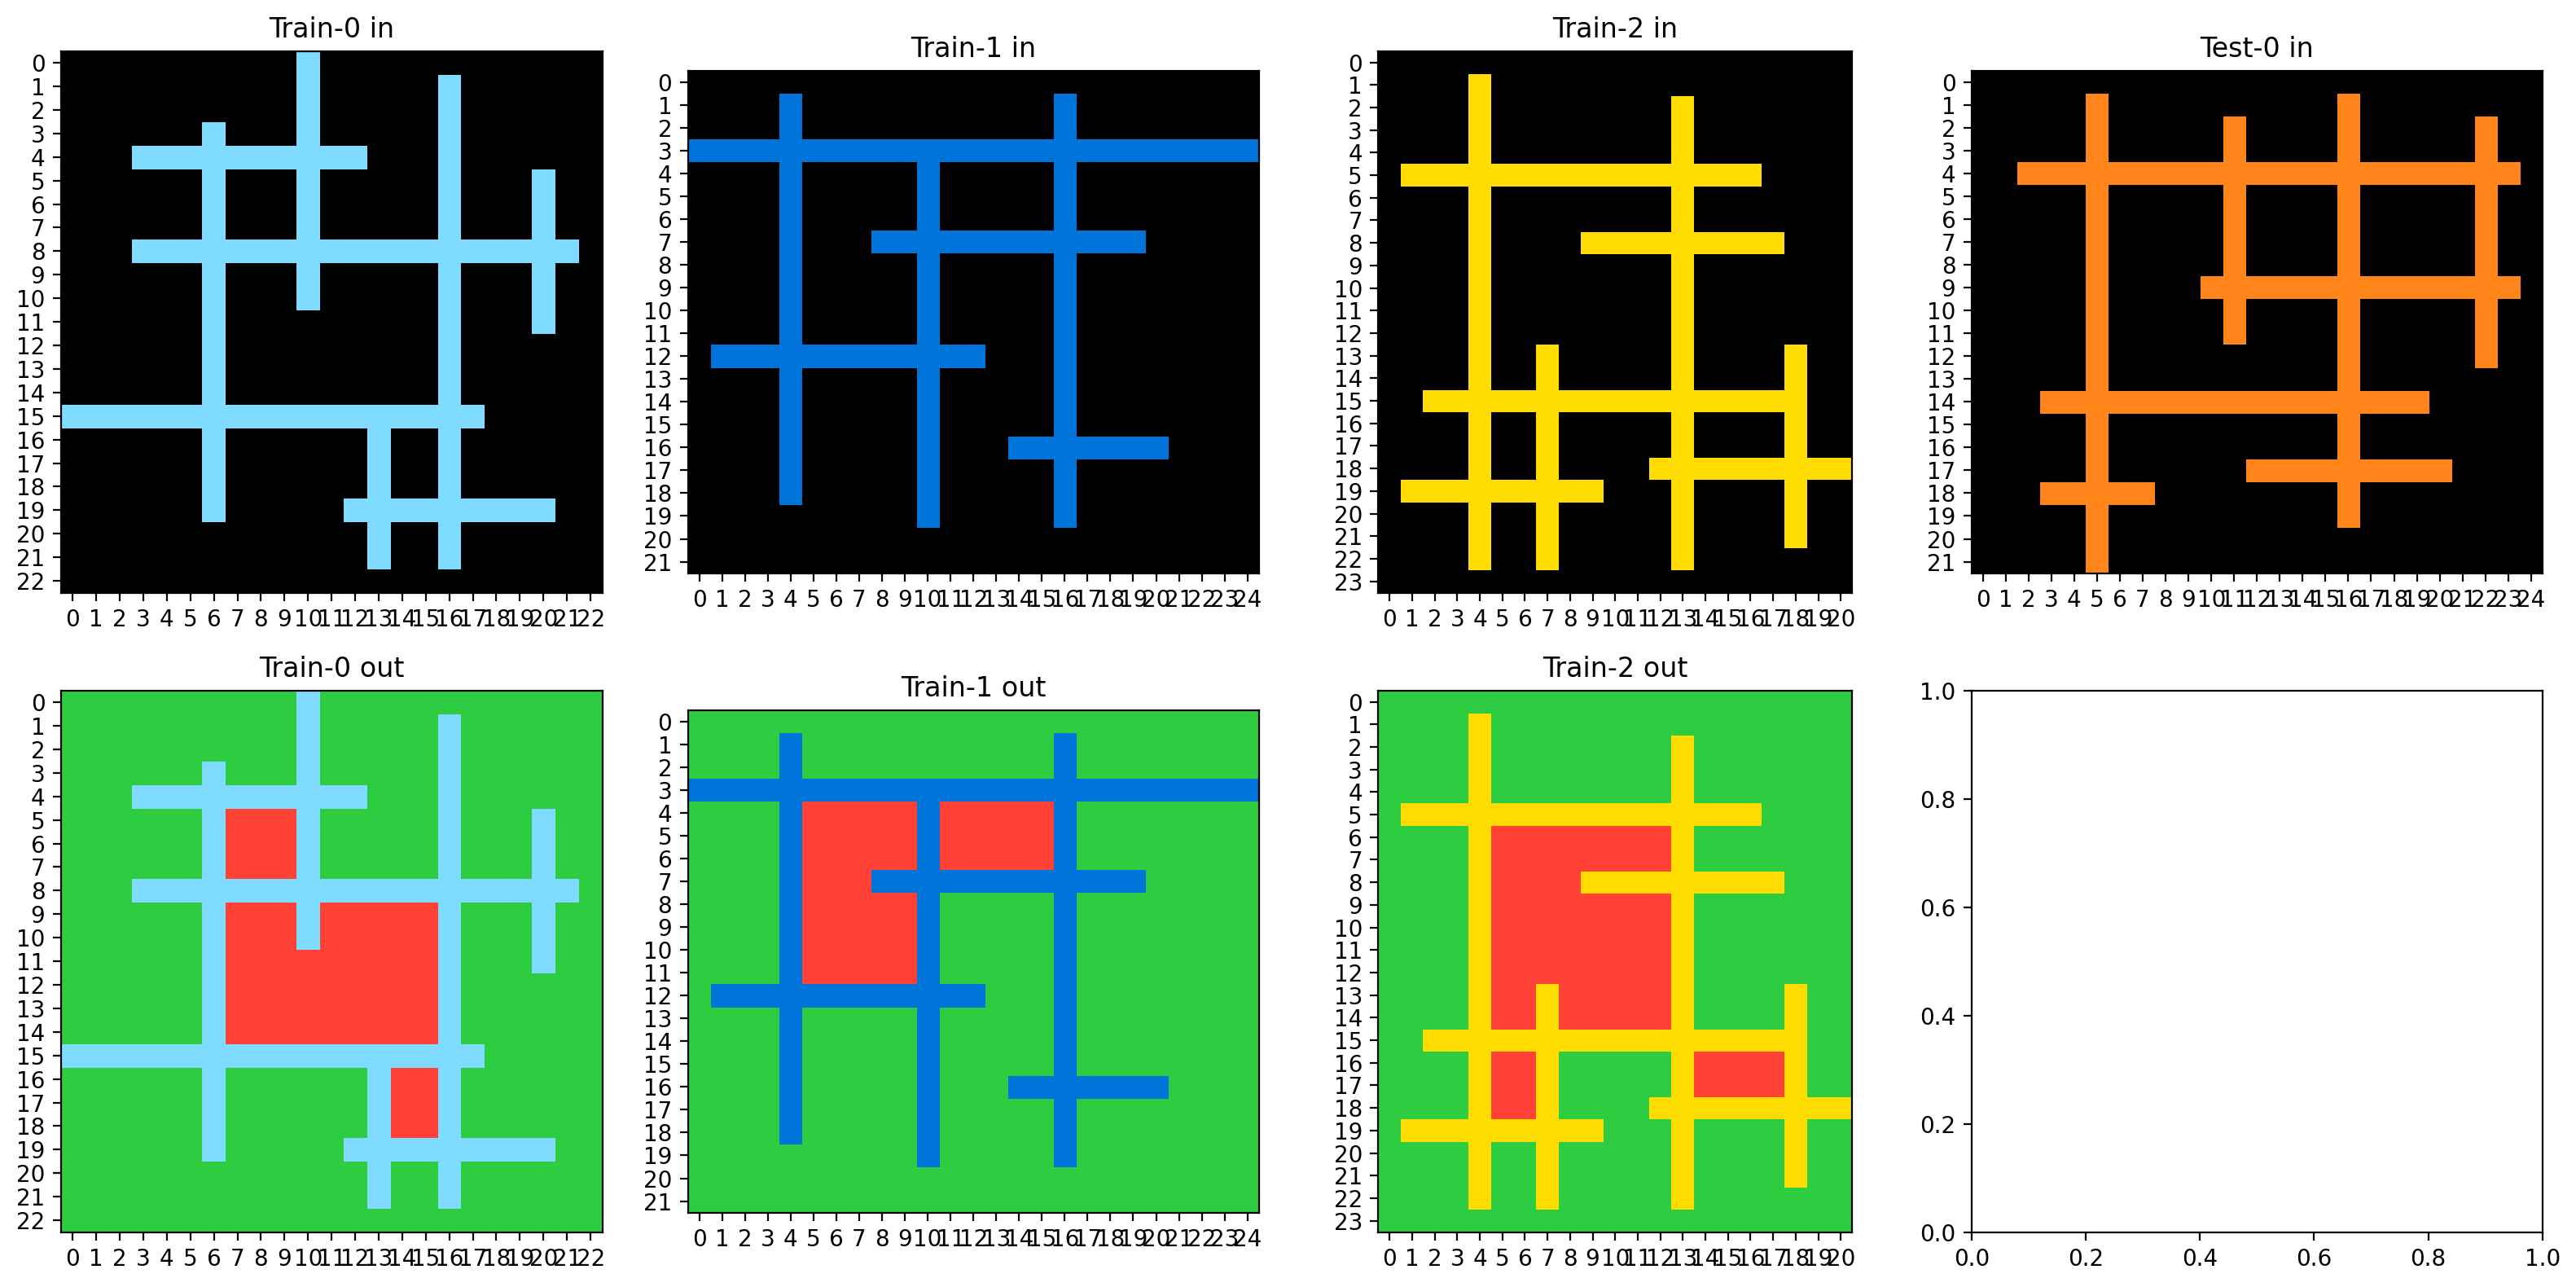

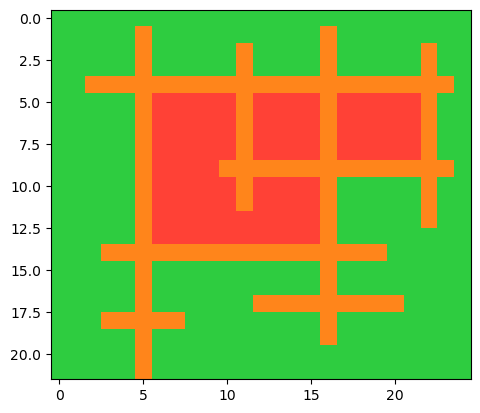

In [13]:
def plot_taskname(data_path, true_output_path, task_name):
    
    
    with open(data_path,'r') as f:
        tasks_name = list(json.load(f).keys())
    
    with open(data_path,'r') as f:
        tasks_file = list(json.load(f).values())
        
    if true_output_path is not None:
        with open(true_output_path,'r') as f:
            true_tasks_file = json.load(f)
            
    
    # ...............................................................................
    for n in range(len(tasks_name)):
        task = tasks_file[n]
        t = tasks_name[n]
        for i in range(len(task['test'])): 
            if t == task_name:
                plot_task(task)
                
                # plot true output
                if true_output_path is not None:
                    plot_pic(true_tasks_file[t][i])
            
            
plot_taskname(train1_path, train2_path, "7b6016b9")

22168020


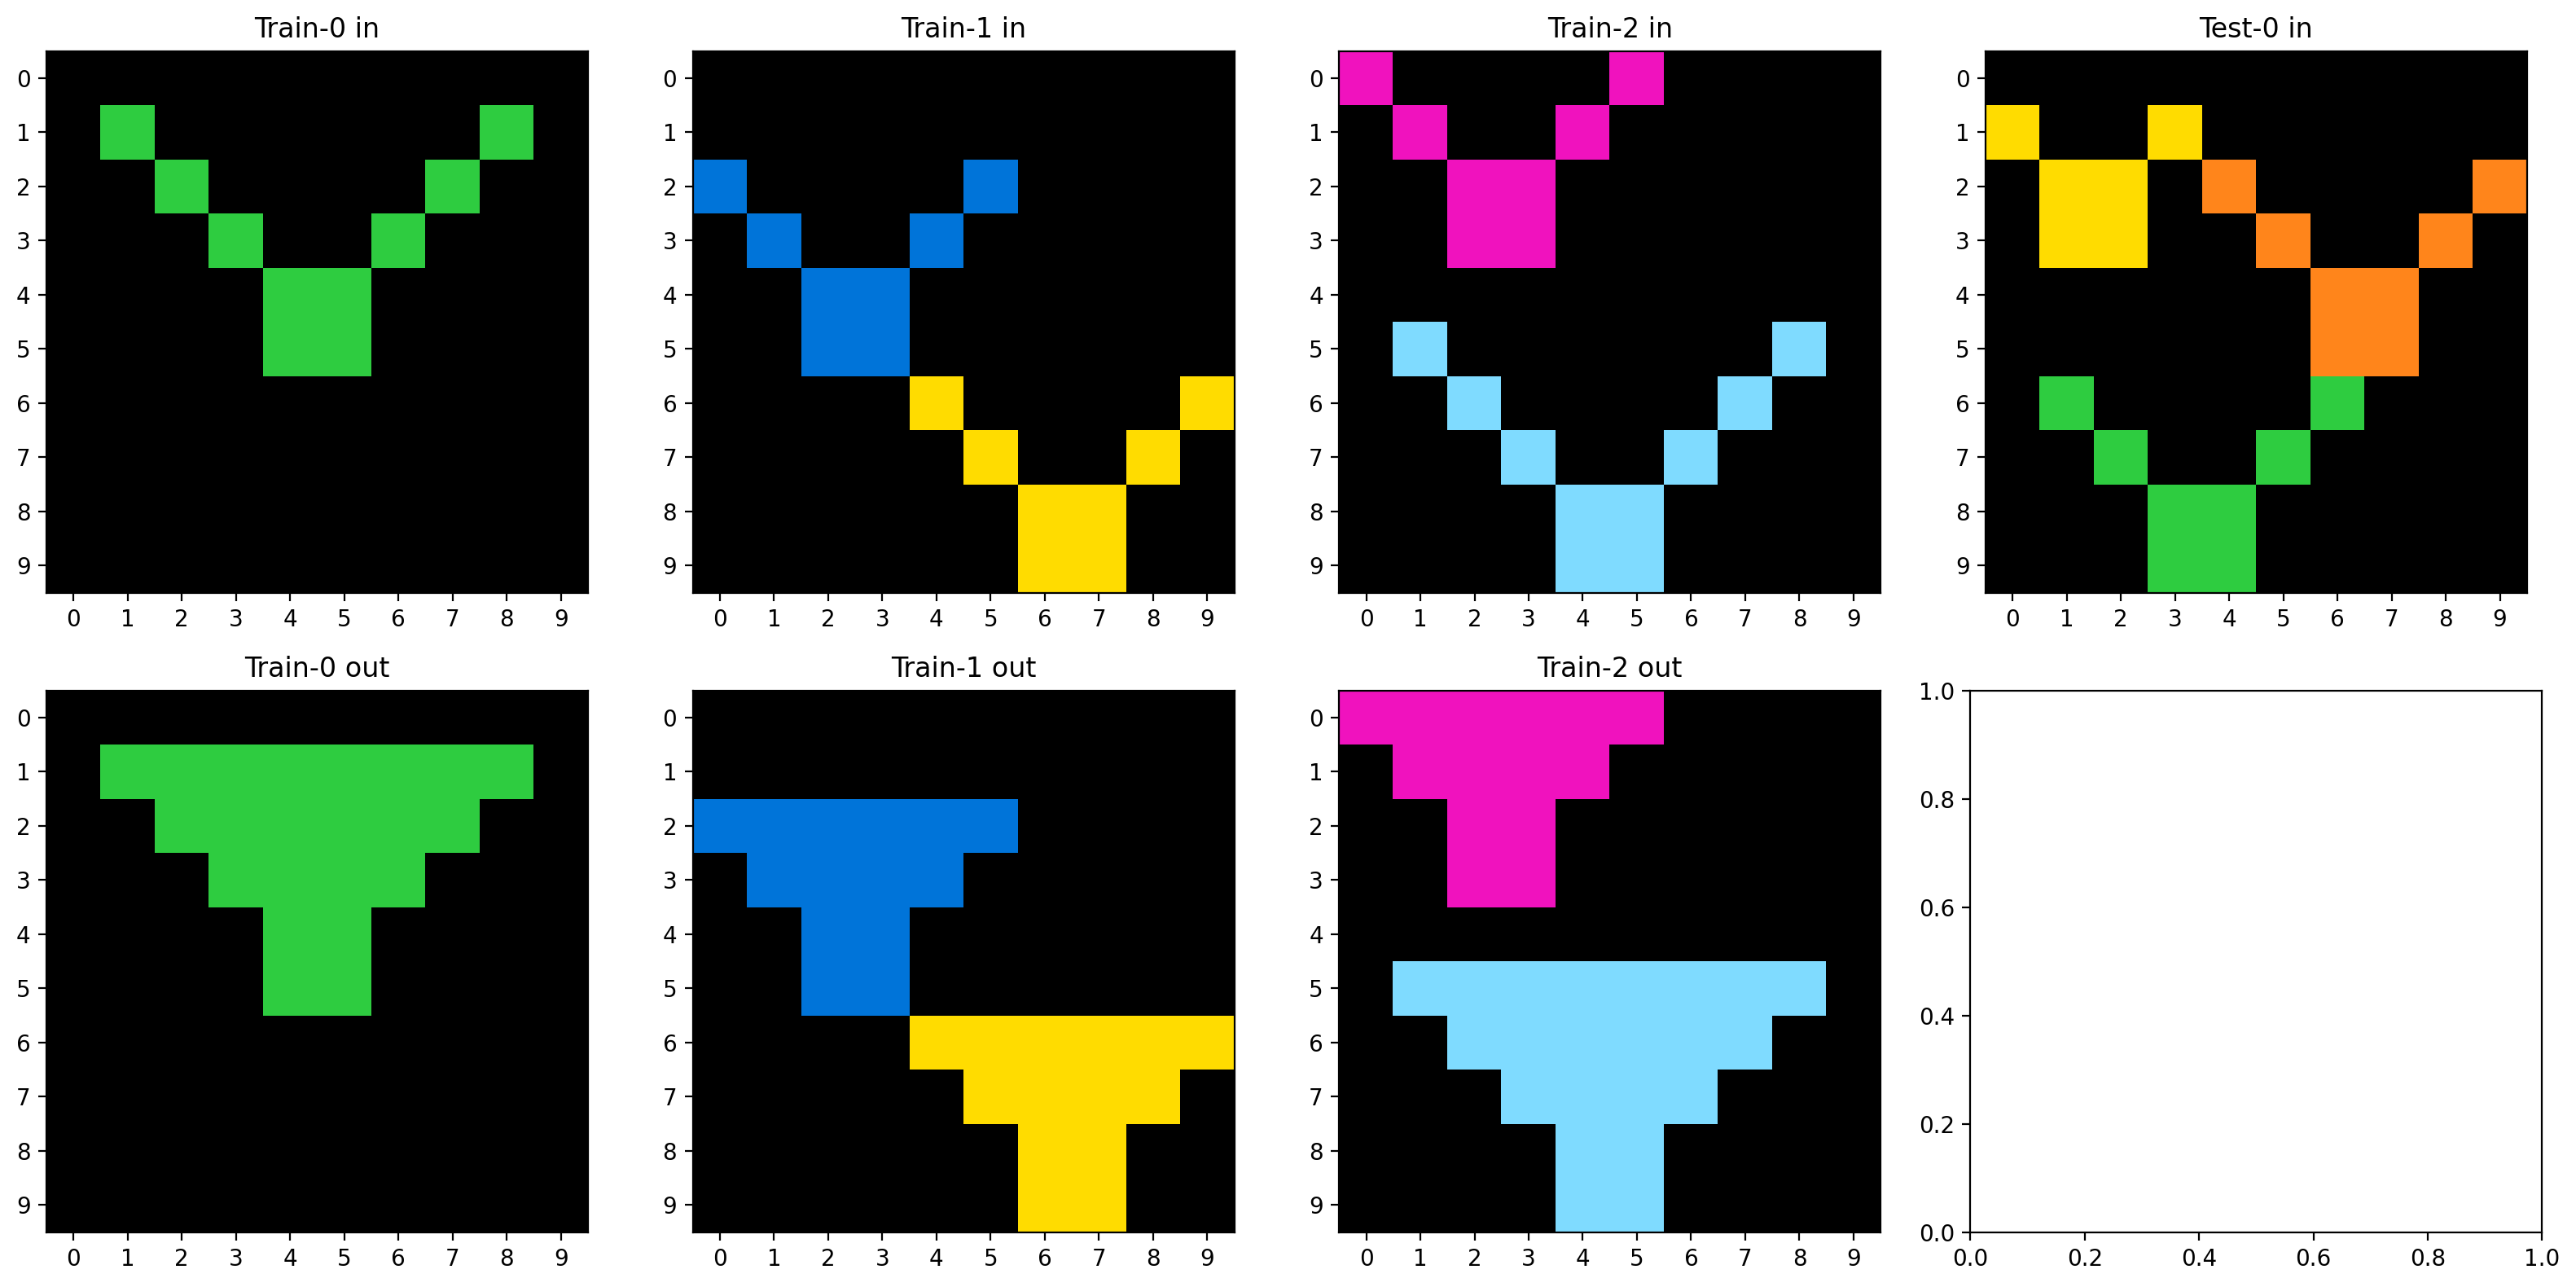

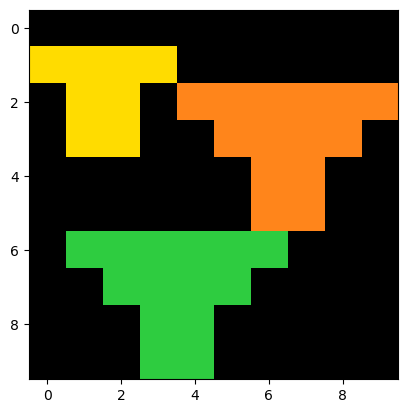

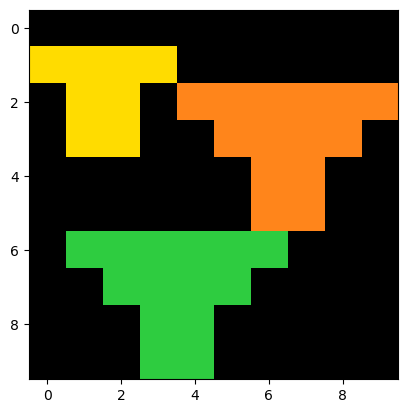

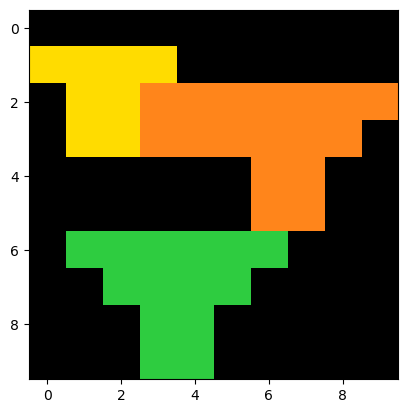

In [14]:
def run_check(data_path, icecube_output_path, true_output_path=None): 
    
    translate_submission(icecube_output_path)
    with open('./sub_icecube.json' , 'r') as f:
        sub_icecube = json.load(f)
    
    with open(data_path,'r') as f:
        tasks_name = list(json.load(f).keys())
    
    with open(data_path,'r') as f:
        tasks_file = list(json.load(f).values())
        
    if true_output_path is not None:
        with open(true_output_path,'r') as f:
            true_tasks_file = json.load(f)
    
    # ...............................................................................
    for n in range(len(tasks_name)):
        task = tasks_file[n]
        t = tasks_name[n]
        
        print(t)
        for i in range(len(task['test'])): 
            test_input = np.array(task['test'][i]['input'])
            prn = []
            plot_task(task)
            
            # plot true output
            if true_output_path is not None:
                plot_pic(true_tasks_file[t][i])
            
            # # plot icecube output
            plot_pic(sub_icecube[t][i]['attempt_1'])
            plot_pic(sub_icecube[t][i]['attempt_2'])
        break
    
run_check(train1_path, train1_icecube_out, train2_path)

## No need to run below code again

In [19]:
def run_check(data_path, icecube_output_path, true_output_path): 
    deep_equal = np.vectorize(np.array_equal)
    def inner_array_equal(a,b): 
        import traceback
        try:
            result = np.all(deep_equal(a,b))
        except:
            result = False
            # traceback.print_exc()
        return result
    
    translate_submission(icecube_output_path)
    with open('./sub_icecube.json' , 'r') as f:
        sub_icecube = json.load(f)
    
    with open(data_path,'r') as f:
        tasks_name = list(json.load(f).keys())
    
    with open(data_path,'r') as f:
        tasks_file = list(json.load(f).values())
        
    if true_output_path is not None:
        with open(true_output_path,'r') as f:
            true_tasks_file = json.load(f)
    
    attempt1_count = 0
    attempt2_count = 0
    total_task = 0
    only1_correct = 0
    only2_correct = 0
    both_correct = 0
    none_correct = 0
    failed_count = 0
    failed_list = []
    
    # ...............................................................................
    for n in range(len(tasks_name)):
        task = tasks_file[n]
        t = tasks_name[n]
        
        # print(t)
        for i in range(len(task['test'])): 
            
            test_input = np.array(task['test'][i]['input'])
            prn = []
            # plot_task(task)
            
            # # plot true output
            # if true_output_path is not None:
            #     plot_pic(true_tasks_file[t][i])
            
            # # # plot icecube output
            # plot_pic(sub_icecube[t][i]['attempt_1'])
            # plot_pic(sub_icecube[t][i]['attempt_2'])
            
            true_pattern = true_tasks_file[t][i]
            
            if t in sub_icecube:
                ice_cube_output1 = sub_icecube[t][i]['attempt_1']
                ice_cube_output2 = sub_icecube[t][i]['attempt_2']
            else:
                ice_cube_output1 = np.array([[0, 0], [0, 0]], dtype=np.float64)
                ice_cube_output2 = np.array([[0, 0], [0, 0]], dtype=np.float64)
                
                failed_count += 1
                failed_list.append(t)
                
                continue
                
            total_task += 1
            true1 = int(inner_array_equal(true_pattern, ice_cube_output1))
            attempt1_count += true1
                
            true2 = int(inner_array_equal(true_pattern, ice_cube_output2))
            attempt2_count += true2
                
            if true1 and not true2:
                only1_correct += 1
                
            if true2 and not true1:
                only2_correct += 1
                
            if true2 and true1:
                both_correct += 1
            
            if not true1 and not true2:
                none_correct += 1
                # plot_task(task)
                
                # # plot true output
                # if true_output_path is not None:
                #     plot_pic(true_tasks_file[t][i])
                
                # # # plot icecube output
                # plot_pic(sub_icecube[t][i]['attempt_1'])
                # plot_pic(sub_icecube[t][i]['attempt_2'])
                
                                
    print(f"total_task (not included failed) {total_task}")
    print(f"attempt1_count {attempt1_count}")
    print(f"attempt2_count {attempt2_count}")
    print(f"only1_correct {only1_correct}")
    print(f"only2_correct {only2_correct}")
    print(f"both_correct {both_correct}")
    print(f"none_correct {none_correct}")
    print(f"failed_count {failed_count}")
    print("failed_list", failed_list)
    
run_check(train1_path, train1_icecube_out, train2_path)

total_task (not included failed) 399
attempt1_count 184
attempt2_count 22
only1_correct 184
only2_correct 22
both_correct 0
none_correct 193
failed_count 17
failed_list ['239be575', '239be575', '27a28665', '27a28665', '27a28665', '44f52bb0', '44f52bb0', '4be741c5', '746b3537', 'a3325580', 'b9b7f026', 'd631b094', 'd9fac9be', 'de1cd16c', 'f8b3ba0a', 'f8ff0b80', 'f9012d9b']


In [64]:
from solver_7 import predict_repeating, check_sub_grid_2x, check_repeating, check_grid, predict_transforms_grid_2x, \
    check_chess, predict_chess, grid_filter, check_tiles_shape, predict_tiles_shape, check_grid_transforms, predict_grid_transforms, \
        check_sub_mask, predict_repeating_mask, check_subitem
from tree import format_features, make_features, tree1
from color_counter import Create, colors_counter
from sym_repairing import symmetry_repairing

In [65]:
# ..................................................................................... 1
def ganswer_answer(ganswer):
    
    answer = []
    for j in range(len(ganswer)):
        ganswer_j = ganswer[j].tolist()
        
        if (ganswer_j not in answer):  
            answer.append(ganswer_j)   
            
    return answer

# ..................................................................................... 2
def ganswer_answer_1(ganswer):
    
    answer = []
    for j in range(len(ganswer)):
        ganswer_j = ganswer[j]
        
        if (ganswer_j not in answer):  
            answer.append(ganswer_j)   
            
    return answer

# ..................................................................................... 3
def prn_plus(prn, answer):
    
    for j in range(len(answer)):
        prn = prn + [answer[j]]  
        
        if (j == 0):
            prn = prn + [answer[j]]
            
    return prn

# ..................................................................................... 4
def prn_select_2(prn): 
    if (len(prn) > 2):
        
        value_list = []
        string_list = []
        for el in prn:
            value = 0
            for i in range(len(prn)):
                if el == prn[i]:
                    value +=1
            value_list.append(value)
            string_list.append(str(el))    
        
        prn_df  = pd.DataFrame({'prn': prn , 'value': value_list, 'string': string_list}) 
        prn_df1 = prn_df.drop_duplicates(subset=['string'])
        prn_df2 = prn_df1.sort_values(by='value', ascending=False)   
        
        prn = prn_df2['prn'].values.tolist()[:2]
        
    return prn

# ..................................................................................... 5
cmap = colors.ListedColormap(
    ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
     '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])

norm = colors.Normalize(vmin=0, vmax=9)
color_list = ["black", "blue", "red", "green", "yellow", "gray", "magenta", "orange", "sky", "brown"]

def plot_pic(x):
    plt.imshow(np.array(x), cmap=cmap, norm=norm)
    plt.show()
    

dict_keys(['007bbfb7', '00d62c1b', '017c7c7b', '025d127b', '045e512c', '0520fde7', '05269061', '05f2a901', '06df4c85', '08ed6ac7', '09629e4f', '0962bcdd', '0a938d79', '0b148d64', '0ca9ddb6', '0d3d703e', '0dfd9992', '0e206a2e', '10fcaaa3', '11852cab', '1190e5a7', '137eaa0f', '150deff5', '178fcbfb', '1a07d186', '1b2d62fb', '1b60fb0c', '1bfc4729', '1c786137', '1caeab9d', '1cf80156', '1e0a9b12', '1e32b0e9', '1f0c79e5', '1f642eb9', '1f85a75f', '1f876c06', '1fad071e', '2013d3e2', '2204b7a8', '22168020', '22233c11', '2281f1f4', '228f6490', '22eb0ac0', '234bbc79', '23581191', '239be575', '23b5c85d', '253bf280', '25d487eb', '25d8a9c8', '25ff71a9', '264363fd', '272f95fa', '27a28665', '28bf18c6', '28e73c20', '29623171', '29c11459', '29ec7d0e', '2bcee788', '2bee17df', '2c608aff', '2dc579da', '2dd70a9a', '2dee498d', '31aa019c', '321b1fc6', '32597951', '3345333e', '3428a4f5', '3618c87e', '3631a71a', '363442ee', '36d67576', '36fdfd69', '3906de3d', '39a8645d', '39e1d7f9', '3aa6fb7a', '3ac3eb23', '3af2

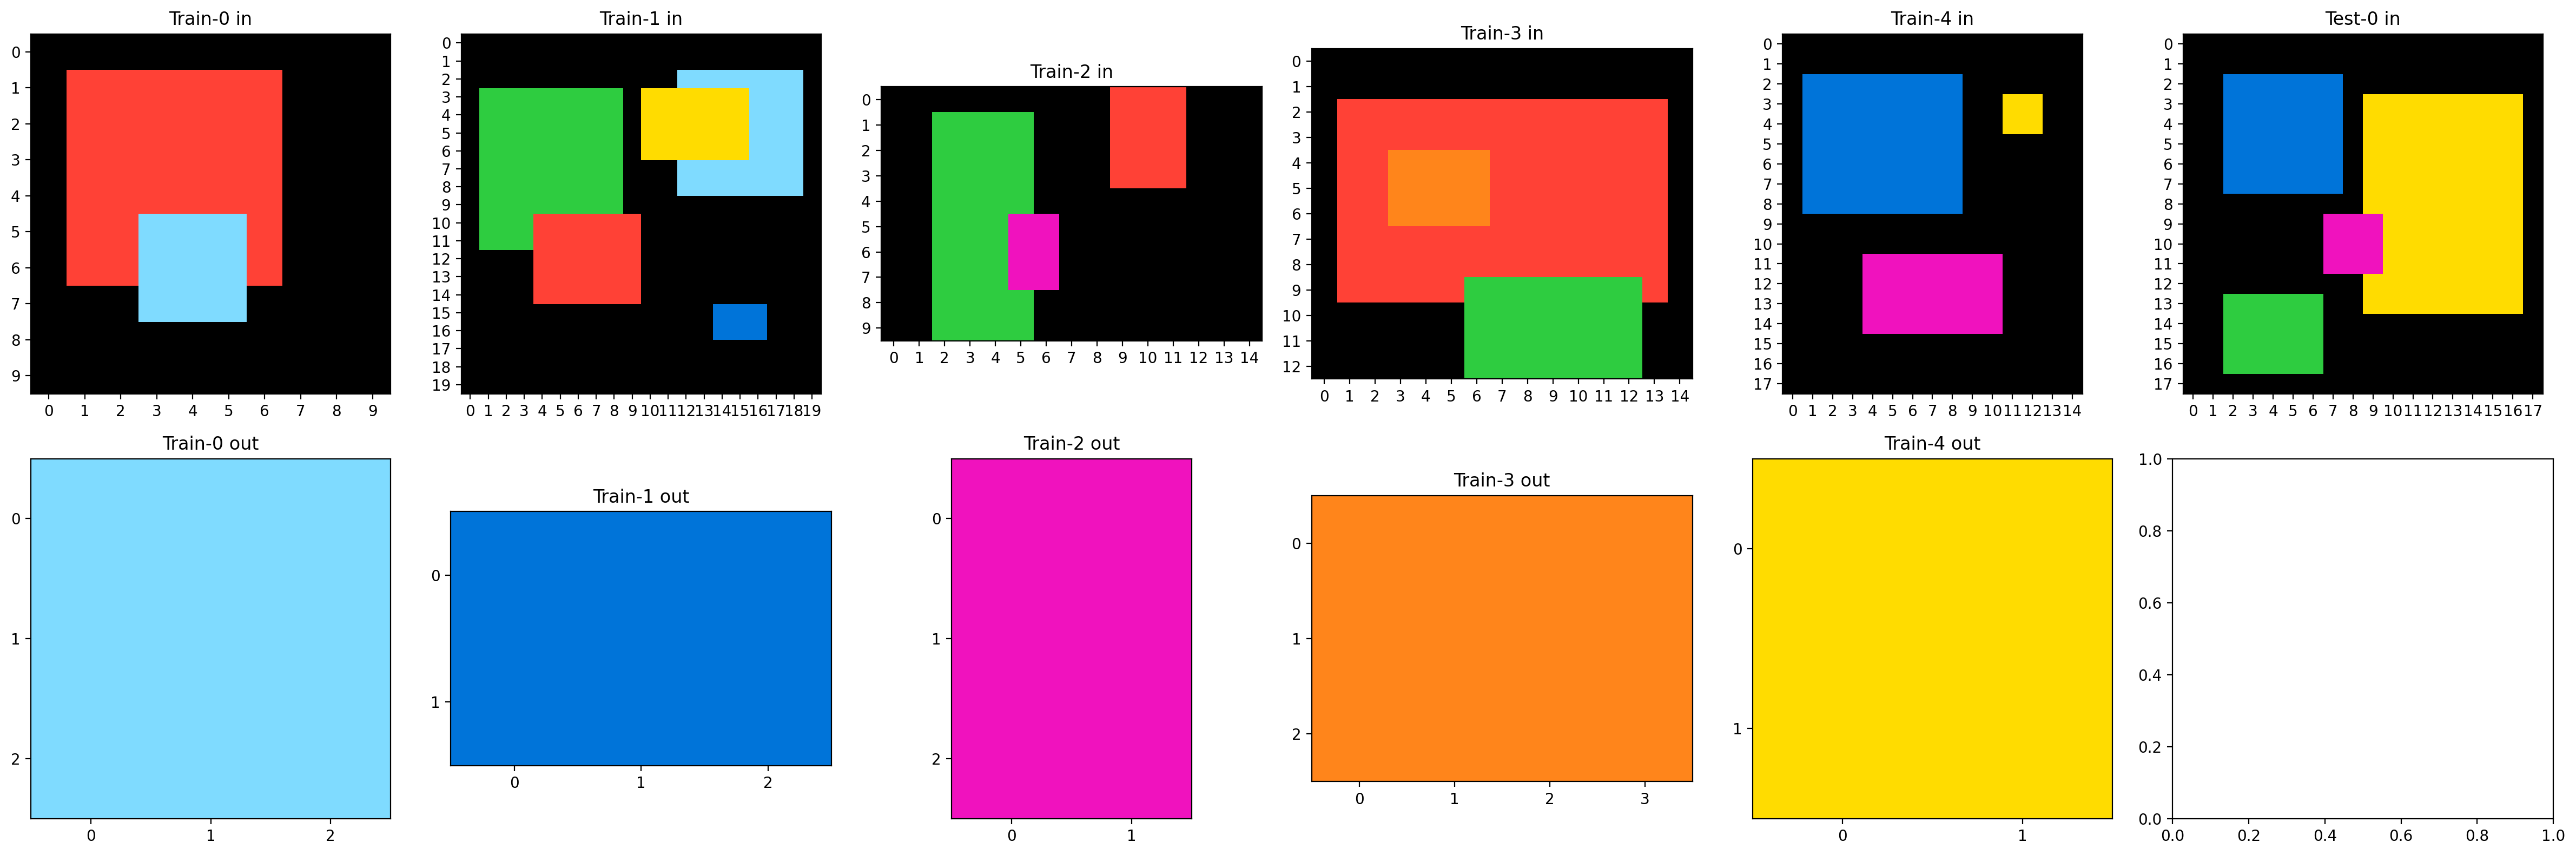

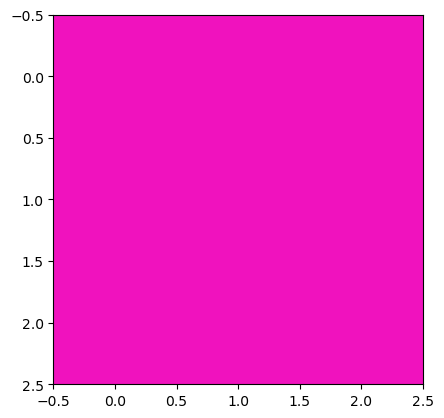

In [84]:
def run_main_solvers(data_path, sample_path, true_output_path): 
    deep_equal = np.vectorize(np.array_equal)
    def inner_array_equal(a,b): 
        import traceback
        try:
            result = np.all(deep_equal(a,b))
        except:
            result = False
            # traceback.print_exc()
        return result

    with open(sample_path,'r') as f:
        sub_solver = json.load(f) 
        
    # ...............................................................................
    with open(data_path,'r') as f:
        tasks_name = list(json.load(f).keys())
    
    with open(data_path,'r') as f:
        tasks_file = list(json.load(f).values())
        
    if true_output_path is not None:
        with open(true_output_path,'r') as f:
            true_tasks_file = json.load(f)
            
    print(sub_solver.keys())
    
    # ...............................................................................
    for n in range(56, len(tasks_file)):
        if n in [56, 56, 64, 64, 64, 108, 108, 120, 181, 246, 290, 338, 345, 354, 390, 392, 393]:
            continue
        task = tasks_file[n]
        t = tasks_name[n]
        # if t != "27a28665":
        #     continue
        print(n)

        for i in range(len(task['test'])): 
            test_input = np.array(task['test'][i]['input'])
            prn = []
            plot_task(task)
            
            # plot true output
            if true_output_path is not None:
                plot_pic(true_tasks_file[t][i])
        break
            
            
run_main_solvers(train1_path, sample_path, train2_path)

In [ ]:
def run_main_solvers(data_path, sample_path, true_output_path): 
    deep_equal = np.vectorize(np.array_equal)
    def inner_array_equal(a,b): 
        import traceback
        try:
            result = np.all(deep_equal(a,b))
        except:
            result = False
            # traceback.print_exc()
        return result

    with open(sample_path,'r') as f:
        sub_solver = json.load(f) 
        
    # ...............................................................................
    with open(data_path,'r') as f:
        tasks_name = list(json.load(f).keys())
    
    with open(data_path,'r') as f:
        tasks_file = list(json.load(f).values())
        
    if true_output_path is not None:
        with open(true_output_path,'r') as f:
            true_tasks_file = json.load(f)
            
    attempt1_count = 0
    attempt2_count = 0
    total_task = 0
    only1_correct = 0
    only2_correct = 0
    both_correct = 0
    none_correct = 0
    failed_count = 0
        
    # ...............................................................................
    for n in range(0, len(tasks_name)):
        if n in [56, 56, 64, 64, 64, 108, 108, 120, 181, 246, 290, 338, 345, 354, 390, 392, 393]:
            continue
        task = tasks_file[n]
        t = tasks_name[n]
        # if t != "27a28665":
        #     continue
        
        for i in range(len(task['test'])): 
            test_input = np.array(task['test'][i]['input'])
            prn = []
                
            # ............................................................................... 1 - Different Solvers       
            if check_repeating(task, True): 
                
                filtered_idx_set = set()
                for j in range(len(task['train'])): 
                    
                    train_input = np.array(task['train'][j]['input'])
                    train_output = np.array(task['train'][j]['output'])
                    ganswer = predict_repeating(train_input)
                    
                    if (ganswer!= []):
                        answer = ganswer_answer(ganswer)
                        prn = prn_plus(prn, answer) 
                        
                        for prn_idx in range(len(prn)):
                            if np.all(prn[prn_idx] == train_output):
                                filtered_idx_set.add(prn_idx)
                    prn = []
                ganswer = predict_repeating(test_input)
                
                if (ganswer!= []):
                    answer = ganswer_answer(ganswer)
                    prn = prn_plus(prn, answer) 
                    filtered_prn = []
                    for filtered_idx in filtered_idx_set:
                        if filtered_idx < len(prn):
                            filtered_prn.append(prn[filtered_idx])
                            
                uniques = []
                for arr in filtered_prn:
                    if not any(np.array_equal(arr, unique_arr) for unique_arr in uniques):
                        uniques.append(arr)
                prn = uniques
                        
            # ________________________________________________________
            if check_grid(task) and check_sub_grid_2x(task): 
                ganswer = predict_transforms_grid_2x(task, test_input)
                
                if (ganswer!= []):
                    answer = ganswer_answer(ganswer)
                    prn = prn_plus(prn, answer) 
         
            # ________________________________________________________
            if check_grid(task) and check_chess(task, False, True): 
                ganswer = predict_chess(grid_filter(test_input))
                
                if (ganswer!= []):
                    answer = ganswer_answer(ganswer)
                    prn = prn_plus(prn, answer) 
                     
            # ________________________________________________________
            if check_tiles_shape(task, True): 
                ganswer = predict_tiles_shape(task, test_input)
                
                if (ganswer!= []):
                    answer = ganswer_answer(ganswer)
                    prn = prn_plus(prn, answer) 
            
            # ________________________________________________________
            if check_grid(task) and check_grid_transforms(task): 
                ganswer = predict_grid_transforms(task, test_input)
                
                if (ganswer!= []):
                    answer = ganswer_answer(ganswer)
                    prn = prn_plus(prn, answer) 
            
            # ________________________________________________________
            if check_sub_mask(task): 
                ganswer = predict_repeating_mask(test_input)
                
                if (ganswer!= []):
                    answer = ganswer_answer(ganswer)
                    prn = prn_plus(prn, answer) 
            
                
  
            # ............................................................................... 2 - Sklearn tree          
            if check_subitem(task):
                train_t = format_features(task)
                print(task)
                test_t = make_features(test_input) 
                ganswer = tree1(train_t, test_t, test_input)  
                
                if (ganswer!= []):
                    answer = ganswer_answer(ganswer)
                    prn = prn_plus(prn, answer) 
                

            # ............................................................................... 3 - Symmetry Repairing       
            basic_task = Create(task, i) 
            ganswer = symmetry_repairing(basic_task)   
        
            if (ganswer != -1):
                answer = ganswer_answer_1(ganswer)
                prn = prn_plus(prn, answer) 
     
            # ............................................................................... 4 - Colors Counter
            basic_task = Create(task, i) 
            answer = colors_counter(basic_task)   
            
            if (answer != -1):
                answer = [answer]
                prn = prn_plus(prn, answer) 
                
            
            # ...............................................................................  Conclusion
            if (prn != []):  
                sub_solver[t] = []
                sub_solver[t].append({})
                
                prn = prn_select_2(prn)
                
                sub_solver[t][i]['attempt_1'] = prn[0]
                display(pd.DataFrame(data={'Answers for task':t, 'Items':i, 'Attempt':'1', 'Files':'test_challenges'},index=[n]))
                # plot_pic(prn[0])
                
                if (len(prn)==1):
                    sub_solver[t][i]['attempt_2'] = prn[0]
                    display(pd.DataFrame(data={'Answers for task':t, 'Items':i, 'Attempt':'2', 'Files':'test_challenges'},index=[n]))
                    # plot_pic(prn[1])
                
                if (len(prn)==2):
                    sub_solver[t][i]['attempt_2'] = prn[1]
                    display(pd.DataFrame(data={'Answers for task':t, 'Items':i, 'Attempt':'2', 'Files':'test_challenges'},index=[n]))
                    # plot_pic(prn[1])

            true_pattern = true_tasks_file[t][i]
            
            if t in sub_solver:
                sub_solver_output1 = sub_solver[t][i]['attempt_1']
                sub_solver_output2 = sub_solver[t][i]['attempt_2']
            else:
                sub_solver_output1 = np.array([[0, 0], [0, 0]], dtype=np.float64)
                sub_solver_output2 = np.array([[0, 0], [0, 0]], dtype=np.float64)
                
                failed_count += 1
                continue
            
            total_task += 1
            true1 = int(inner_array_equal(true_pattern, sub_solver_output1))
            attempt1_count += true1
                
            true2 = int(inner_array_equal(true_pattern, sub_solver_output2))
            attempt2_count += true2
                
            if true1 and not true2:
                only1_correct += 1
                
            if true2 and not true1:
                only2_correct += 1
                
            if true2 and true1:
                both_correct += 1
            
            if not true1 and not true2:
                none_correct += 1
            
    print(f"total_task (not included failed) {total_task}")
    print(f"attempt1_count {attempt1_count}")
    print(f"attempt2_count {attempt2_count}")
    print(f"only1_correct {only1_correct}")
    print(f"only2_correct {only2_correct}")
    print(f"both_correct {both_correct}")
    print(f"none_correct {none_correct}")
    print(f"failed_count {failed_count}")
            
    return sub_solver

sub_solver = run_main_solvers(train1_path, sample_path, train2_path)

In [121]:
with open("sub_solver.json", "w") as f:
    json.dump(sub_solver, f, indent=4)

## Main part

In [15]:
def get_not_solve_task(data_path, icecube_output_path, true_output_path): 
    deep_equal = np.vectorize(np.array_equal)
    def inner_array_equal(a,b): 
        import traceback
        try:
            result = np.all(deep_equal(a,b))
        except:
            result = False
            # traceback.print_exc()
        return result
    
    translate_submission(icecube_output_path)
    with open('./sub_icecube.json' , 'r') as f:
        sub_icecube = json.load(f)
        
    with open('./sub_solver.json' , 'r') as f:
        sub_solver = json.load(f)
    
    with open(data_path,'r') as f:
        tasks_name = list(json.load(f).keys())
    
    with open(data_path,'r') as f:
        tasks_file = list(json.load(f).values())
        
    if true_output_path is not None:
        with open(true_output_path,'r') as f:
            true_tasks_file = json.load(f)
    
    total_task = 0
    failed_count = 0
    failed_list = []
    correct_task = 0
    incorrect_list = []
    
    # ...............................................................................
    for n in range(len(tasks_name)):
        task = tasks_file[n]
        t = tasks_name[n]
        
        # print(t)
        for i in range(len(task['test'])): 
            
            test_input = np.array(task['test'][i]['input'])
            prn = []
            # plot_task(task)
            
            # # plot true output
            # if true_output_path is not None:
            #     plot_pic(true_tasks_file[t][i])
            
            # # # plot icecube output
            # plot_pic(sub_icecube[t][i]['attempt_1'])
            # plot_pic(sub_icecube[t][i]['attempt_2'])
            
            true_pattern = true_tasks_file[t][i]
            
            if t in sub_icecube:
                ice_cube_output1 = sub_icecube[t][i]['attempt_1']
                ice_cube_output2 = sub_icecube[t][i]['attempt_2']
            else:
                ice_cube_output1 = np.array([[0, 0], [0, 0]], dtype=np.float64)
                ice_cube_output2 = np.array([[0, 0], [0, 0]], dtype=np.float64)
                
                failed_count += 1
                failed_list.append(n)
                continue
                
            if t in sub_solver:
                sub_solver_output1 = sub_solver[t][i]['attempt_1']
                sub_solver_output2 = sub_solver[t][i]['attempt_2']
            else:
                sub_solver_output1 = np.array([[0, 0], [0, 0]], dtype=np.float64)
                sub_solver_output2 = np.array([[0, 0], [0, 0]], dtype=np.float64)
                
            total_task += 1
            
            equal_arr = [
                inner_array_equal(true_pattern, sub_solver_output1),
                inner_array_equal(true_pattern, sub_solver_output2),
                inner_array_equal(true_pattern, ice_cube_output1),
                inner_array_equal(true_pattern, ice_cube_output2),
            ]
            
            if np.any(equal_arr):
                correct_task += 1
            else:
                incorrect_list.append(t)
            
    print(f"correct_task {correct_task}")
    return incorrect_list
    
incorrect_list = get_not_solve_task(train1_path, train1_icecube_out, train2_path)

correct_task 217


In [16]:
print(*incorrect_list, sep=", ")

29623171, 50846271, 82819916, 91413438, 95990924, 97999447, 017c7c7b, 045e512c, 05f2a901, 08ed6ac7, 0a938d79, 0ca9ddb6, 0e206a2e, 10fcaaa3, 11852cab, 137eaa0f, 150deff5, 1a07d186, 1b60fb0c, 1caeab9d, 1f642eb9, 22233c11, 2281f1f4, 234bbc79, 25d8a9c8, 264363fd, 28e73c20, 29c11459, 2c608aff, 2dd70a9a, 321b1fc6, 3428a4f5, 3428a4f5, 363442ee, 36d67576, 36fdfd69, 39a8645d, 39e1d7f9, 3ac3eb23, 3bdb4ada, 3befdf3e, 3de23699, 3e980e27, 3eda0437, 3f7978a0, 4093f84a, 41e4d17e, 4290ef0e, 447fd412, 44d8ac46, 4522001f, 4612dd53, 46442a0e, 469497ad, 46f33fce, 4938f0c2, 4c5c2cf0, 508bd3b6, 5168d44c, 539a4f51, 53b68214, 54d9e175, 57aa92db, 5c0a986e, 5c2c9af4, 5daaa586, 60b61512, 673ef223, 6855a6e4, 6a1e5592, 6aa20dc0, 6b9890af, 6cf79266, 6d0160f0, 6e02f1e3, 6e19193c, 6ecd11f4, 72322fa7, 7447852a, 760b3cac, 776ffc46, 7837ac64, 794b24be, 7b7f7511, 7c008303, 7ddcd7ec, 7df24a62, 7e0986d6, 7f4411dc, 7fe24cdd, 8403a5d5, 846bdb03, 855e0971, 85c4e7cd, 868de0fa, 8731374e, 88a10436, 890034e9, 8a004b2b, 90f3ed37, 

In [18]:
def display_unsolve_task(data_path, true_output_path, incorrect_list, task_index=None, icecube_output_path=None): 
    if icecube_output_path is not None:
        translate_submission(icecube_output_path)
        with open('./sub_icecube.json' , 'r') as f:
            sub_icecube = json.load(f)
    
    with open(data_path,'r') as f:
        tasks_name = list(json.load(f).keys())
    
    with open(data_path,'r') as f:
        tasks_file = list(json.load(f).values())
        
    with open(true_output_path,'r') as f:
        true_tasks_file = json.load(f)
        
    sub_solver = None
    with open('./sub_solver.json' , 'r') as f:
        sub_solver = json.load(f)
    
    if task_index is not None:
        task_name = incorrect_list[task_index]
        n = tasks_name.index(task_name)
        task = tasks_file[n]
        t = tasks_name[n]
        
        for i in range(len(task['test'])): 
           
            plot_task(task)
            
            # plot true output
            if true_output_path is not None:
                plt.title("true_tasks output")
                plot_pic(true_tasks_file[t][i])
            
            # # plot icecube output
            if icecube_output_path is not None and t in sub_icecube:
                plt.title("ice_cube attempt 1")
                plot_pic(sub_icecube[t][i]['attempt_1'])
                plt.title("ice_cube attempt 2")
                plot_pic(sub_icecube[t][i]['attempt_2'])
                
                
            if sub_solver is not None and t in sub_solver:
                plt.title("sub_solver attempt 1")
                plot_pic(sub_solver[t][i]['attempt_1'])
                plt.title("sub_solver attempt 2")
                plot_pic(sub_solver[t][i]['attempt_2'])
                
# display_unsolve_task(train1_path, train2_path, incorrect_list, 7, train1_icecube_out)

In [32]:
def run_check_alejandro(data_path, alejandro_output_path, true_output_path=None): 
    deep_equal = np.vectorize(np.array_equal)
    def inner_array_equal(a,b): 
        import traceback
        try:
            result = np.all(deep_equal(a,b))
        except:
            result = False
            # traceback.print_exc()
        return result
    
    translate_submission(alejandro_output_path, "./sub_alejandro.json")
    with open("./sub_alejandro.json" , 'r') as f:
        sub_alejandro = json.load(f)
    
    with open(data_path,'r') as f:
        tasks_name = list(json.load(f).keys())
    
    with open(data_path,'r') as f:
        tasks_file = list(json.load(f).values())
        
    if true_output_path is not None:
        with open(true_output_path,'r') as f:
            true_tasks_file = json.load(f)
    
    attempt1_count = 0
    attempt2_count = 0
    total_task = 0
    only1_correct = 0
    only2_correct = 0
    both_correct = 0
    none_correct = 0
    failed_count = 0
    failed_list = []
    
    # ...............................................................................
    for n in range(len(tasks_name)):
        task = tasks_file[n]
        t = tasks_name[n]
        
        # print(t)
        for i in range(len(task['test'])): 
            
            test_input = np.array(task['test'][i]['input'])
            prn = []
            # plot_task(task)
            
            # # plot true output
            # if true_output_path is not None:
            #     plot_pic(true_tasks_file[t][i])
            
            # # # plot icecube output
            # plot_pic(sub_icecube[t][i]['attempt_1'])
            # plot_pic(sub_icecube[t][i]['attempt_2'])
            
            true_pattern = true_tasks_file[t][i]
            
            if t in sub_alejandro:
                ice_cube_output1 = sub_alejandro[t][i]['attempt_1']
                ice_cube_output2 = sub_alejandro[t][i]['attempt_2']
            else:
                ice_cube_output1 = np.array([[0, 0], [0, 0]], dtype=np.float64)
                ice_cube_output2 = np.array([[0, 0], [0, 0]], dtype=np.float64)
                
                failed_count += 1
                failed_list.append(t)
                continue
                
            total_task += 1
            true1 = int(inner_array_equal(true_pattern, ice_cube_output1))
            attempt1_count += true1
                
            true2 = int(inner_array_equal(true_pattern, ice_cube_output2))
            attempt2_count += true2
                
            if true1 and not true2:
                only1_correct += 1
                
            if true2 and not true1:
                only2_correct += 1
                
            if true2 and true1:
                both_correct += 1
            
            if not true1 and not true2:
                none_correct += 1
                # plot_task(task)
                
                # # plot true output
                # if true_output_path is not None:
                #     plot_pic(true_tasks_file[t][i])
                
                # # # plot icecube output
                # plot_pic(sub_icecube[t][i]['attempt_1'])
                # plot_pic(sub_icecube[t][i]['attempt_2'])
                
                                
    print(f"total_task (not included failed) {total_task}")
    print(f"attempt1_count {attempt1_count}")
    print(f"attempt2_count {attempt2_count}")
    print(f"only1_correct {only1_correct}")
    print(f"only2_correct {only2_correct}")
    print(f"both_correct {both_correct}")
    print(f"none_correct {none_correct}")
    print(f"failed_count {failed_count}")
    print("failed_list", failed_list)
    
alejandro_output_path = "../ARC_Kaggle/alejandro_train_submission_test.csv"
run_check_alejandro(train1_path, alejandro_output_path, train2_path)

total_task (not included failed) 399
attempt1_count 85
attempt2_count 85
only1_correct 58
only2_correct 58
both_correct 27
none_correct 256
failed_count 17
failed_list ['239be575', '239be575', '27a28665', '27a28665', '27a28665', '44f52bb0', '44f52bb0', '4be741c5', '746b3537', 'a3325580', 'b9b7f026', 'd631b094', 'd9fac9be', 'de1cd16c', 'f8b3ba0a', 'f8ff0b80', 'f9012d9b']


In [33]:
def get_not_solve_task(data_path, icecube_output_path, alejandro_output_path, true_output_path): 
    deep_equal = np.vectorize(np.array_equal)
    def inner_array_equal(a,b): 
        import traceback
        try:
            result = np.all(deep_equal(a,b))
        except:
            result = False
            # traceback.print_exc()
        return result
    
    translate_submission(alejandro_output_path, "./sub_alejandro.json")
    with open("./sub_alejandro.json" , 'r') as f:
        sub_alejandro = json.load(f)
    
    translate_submission(icecube_output_path)
    with open('./sub_icecube.json' , 'r') as f:
        sub_icecube = json.load(f)
        
    with open('./sub_solver.json' , 'r') as f:
        sub_solver = json.load(f)
    
    with open(data_path,'r') as f:
        tasks_name = list(json.load(f).keys())
    
    with open(data_path,'r') as f:
        tasks_file = list(json.load(f).values())
        
    if true_output_path is not None:
        with open(true_output_path,'r') as f:
            true_tasks_file = json.load(f)
    
    total_task = 0
    failed_count = 0
    failed_list = []
    correct_task = 0
    incorrect_list = []
    
    # ...............................................................................
    for n in range(len(tasks_name)):
        task = tasks_file[n]
        t = tasks_name[n]
        
        # print(t)
        for i in range(len(task['test'])): 
            
            test_input = np.array(task['test'][i]['input'])
            prn = []
            # plot_task(task)
            
            # # plot true output
            # if true_output_path is not None:
            #     plot_pic(true_tasks_file[t][i])
            
            # # # plot icecube output
            # plot_pic(sub_icecube[t][i]['attempt_1'])
            # plot_pic(sub_icecube[t][i]['attempt_2'])
            
            true_pattern = true_tasks_file[t][i]
            
            if t in sub_icecube:
                ice_cube_output1 = sub_icecube[t][i]['attempt_1']
                ice_cube_output2 = sub_icecube[t][i]['attempt_2']
            else:
                ice_cube_output1 = np.array([[0, 0], [0, 0]], dtype=np.float64)
                ice_cube_output2 = np.array([[0, 0], [0, 0]], dtype=np.float64)
                
                failed_count += 1
                failed_list.append(n)
                continue
            
            if t in sub_alejandro:
                alejandro_output1 = sub_alejandro[t][i]['attempt_1']
                alejandro_output2 = sub_alejandro[t][i]['attempt_2']
            else:
                alejandro_output1 = np.array([[0, 0], [0, 0]], dtype=np.float64)
                alejandro_output2 = np.array([[0, 0], [0, 0]], dtype=np.float64)
                
            if t in sub_solver:
                sub_solver_output1 = sub_solver[t][i]['attempt_1']
                sub_solver_output2 = sub_solver[t][i]['attempt_2']
            else:
                sub_solver_output1 = np.array([[0, 0], [0, 0]], dtype=np.float64)
                sub_solver_output2 = np.array([[0, 0], [0, 0]], dtype=np.float64)
                
            total_task += 1
            
            equal_arr = [
                inner_array_equal(true_pattern, sub_solver_output1),
                inner_array_equal(true_pattern, sub_solver_output2),
                inner_array_equal(true_pattern, ice_cube_output1),
                inner_array_equal(true_pattern, ice_cube_output2),
                inner_array_equal(true_pattern, alejandro_output1),
                inner_array_equal(true_pattern, alejandro_output2),
            ]
            
            if np.any(equal_arr):
                correct_task += 1
            else:
                incorrect_list.append(t)
            
    print(f"correct_task {correct_task}")
    return incorrect_list
    
incorrect_list = get_not_solve_task(train1_path, train1_icecube_out, alejandro_output_path, train2_path)

correct_task 257


-> Add alejandro result, the correct task increase from 217 to 257